In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 




import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'brk'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_distilbert_dep_brk_about'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.4897959183673469
MALE 1.0
FEMALE 0.0 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5189393939393939
MALE 1.0
FEMALE 0.0 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.516297262059974
MALE 1.0
FEMALE 0.0 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6818696458788284 	 Validation loss: 0.6822899630514242 	 
  1%|          | 574/57400 [02:40<3:46:36,  4.18it/s]
Epoch 2 	 Training loss: 0.6767281237794962 	 Validation loss: 0.6757951762716649 	 
  2%|▏         | 1148/57400 [04:55<3:23:04,  4.62it/s]
Epoch 3 	 Training loss: 0.6621792022567178 	 Validation loss: 0.6470782585063223 	 
  3%|▎         | 1722/57400 [07:26<4:04:32,  3.79it/s]
Epoch 4 	 Training loss: 0.5990668868561655 	 Validation loss: 0.5351735116061518 	 
  4%|▍         | 2296/57400 [10:08<4:27:19,  3.44it/s]
Epoch 5 	 Training loss: 0.4922822005657369 	 Validation loss: 0.44824110400878775 	 
  5%|▌         | 2870/57400 [12:56<4:21:33,  3.47it/s]
Epoch 6 	 Training loss: 0.4367959383576589 	 Validation loss: 0.40408331105264567 	 
  6%|▌         | 3444/57400 [16:07<3:50:04,  3.91it/s]
Epoch 7 	 Training loss: 0.40649882530086134 	 Validation loss: 0.3810830389038991 	 
  7%|▋         | 4018/57400 [19:18<4:50:43,  3.06it/s]
Epoch 8 	 Training

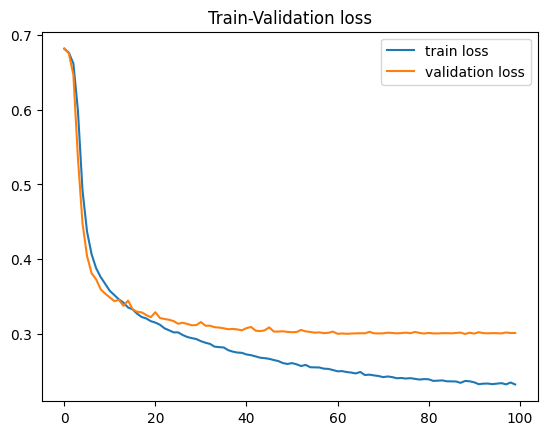

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8405612244897959
MALE 0.8359375
FEMALE 0.845 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6553030303030303
MALE 0.681265206812652
FEMALE 0.6272965879265092 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6779661016949152
MALE 0.6691919191919192
FEMALE 0.6873315363881402 



# TO

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_distilbert_dep_brk_to'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6948792987376555 	 Validation loss: 0.6934451339608532 	 
  1%|          | 574/57400 [02:41<2:53:09,  5.47it/s]
Epoch 2 	 Training loss: 0.6945311980588096 	 Validation loss: 0.6928529466612864 	 
  2%|▏         | 1148/57400 [04:57<3:39:56,  4.26it/s]
Epoch 3 	 Training loss: 0.6941756660099229 	 Validation loss: 0.6926712646322736 	 
  3%|▎         | 1722/57400 [07:14<2:44:12,  5.65it/s]
Epoch 4 	 Training loss: 0.694059441521608 	 Validation loss: 0.6946161419658338 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [10:07<4:04:28,  3.76it/s]
Epoch 5 	 Training loss: 0.6940335831783374 	 Validation loss: 0.6941187755536224 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [12:36<3:35:36,  4.22it/s]
Epoch 6 	 Training loss: 0.6939043488859715 	 Validation loss: 0.6932834821232294 	 
  6%|▌         | 3444/57400 [14:58<3:44:13,  4.01it/s]
Epoch 7 	 Training loss: 0.6937163346528176 	 Validation loss: 0.6924153788615082 	 
  7%|▋         | 40

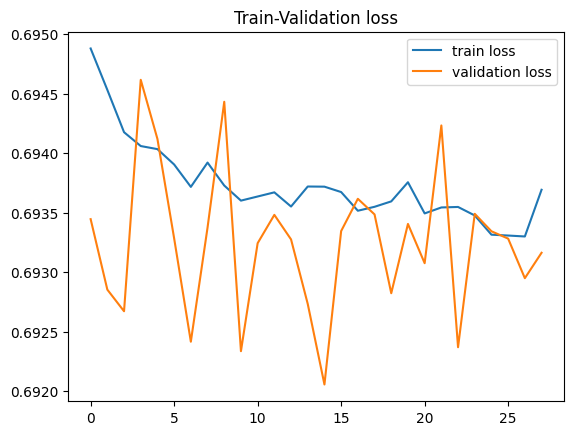

In [20]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.4961734693877551
MALE 0.14583333333333334
FEMALE 0.8325 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.51010101010101
MALE 0.1654501216545012
FEMALE 0.8818897637795275 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.516297262059974
MALE 0.18686868686868688
FEMALE 0.8679245283018868 



# AS

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_distilbert_dep_brk_as'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6944421470580616 	 Validation loss: 0.6934037279274504 	 
  1%|          | 574/57400 [02:35<4:02:00,  3.91it/s]
Epoch 2 	 Training loss: 0.6940314255732692 	 Validation loss: 0.692446343979593 	 
  2%|▏         | 1148/57400 [05:11<4:12:58,  3.71it/s]
Epoch 3 	 Training loss: 0.6938495616256568 	 Validation loss: 0.6926020989983769 	 
  3%|▎         | 1722/57400 [07:47<4:16:29,  3.62it/s]
Epoch 4 	 Training loss: 0.6937058335397301 	 Validation loss: 0.6932036917088396 	 
  4%|▍         | 2296/57400 [10:30<4:57:32,  3.09it/s]
Epoch 5 	 Training loss: 0.6934973682676043 	 Validation loss: 0.6930184930057849 	 
  5%|▌         | 2870/57400 [13:38<4:23:02,  3.46it/s]
Epoch 6 	 Training loss: 0.6931593741066364 	 Validation loss: 0.6920736583612733 	 
  6%|▌         | 3444/57400 [16:14<3:55:22,  3.82it/s]
Epoch 7 	 Training loss: 0.6931115129268128 	 Validation loss: 0.691993567903163 	 
  7%|▋         | 4018/57400 [18:52<3:13:40,  4.59it/s]
Epoch 8 	 Training loss

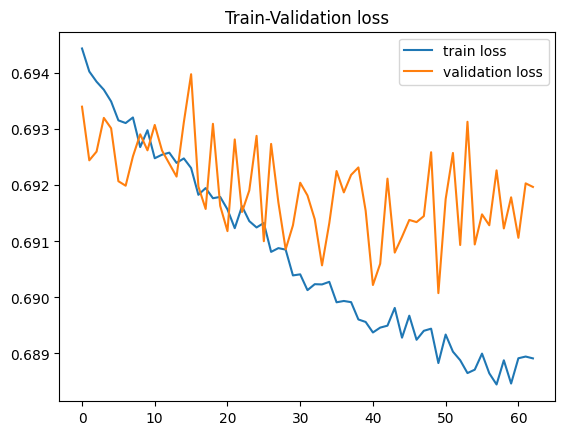

In [23]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [24]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.6964285714285714
MALE 0.59375
FEMALE 0.795 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.61489898989899
MALE 0.5182481751824818
FEMALE 0.7191601049868767 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6453715775749674
MALE 0.46464646464646464
FEMALE 0.8382749326145552 

